In [ ]:
# Name - Nalawade Prafulla Chandrashekhar.
# Class - BE Artificial Intelligence and Data Science.
# Roll No - 42
# Practical No. 10 - Create and Art with Neural style transfer on given image using deep learning.

In [1]:
# Import Required Libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import vgg19


In [3]:
# Load and Preprocess Image

In [4]:
def load_and_process_img(img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_img(img):
    img = img.squeeze()
    img = img + [103.939, 116.779, 123.68]  # Convert back to BGR
    img = np.clip(img, 0, 255).astype('uint8')
    return img


In [5]:
# Load the Content and Style Images


In [6]:
content_path = r"C:\Users\saira\Downloads\Content.jpg"  
style_path = r"C:\Users\saira\Downloads\style.jpg"     

content_img = load_and_process_img(content_path)
style_img = load_and_process_img(style_path)


In [7]:
# Load the VGG19 Model

In [8]:
model = vgg19.VGG19(weights='imagenet', include_top=False)

# Define the layers we will use for content and style
content_layer = 'block5_conv2'  # Content layer
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


In [9]:
# Define a Function to Get Feature Representations

In [10]:
def get_feature_representations(model, content_img, style_img):
    content_output = model.get_layer(content_layer).output
    style_outputs = [model.get_layer(layer).output for layer in style_layers]
    
    model = tf.keras.models.Model(inputs=model.input, outputs=[content_output] + style_outputs)
    
    content_features = model(content_img)
    style_features = model(style_img)
    
    content_feature = content_features[0]
    style_features = style_features[1:]
    
    return content_feature, style_features


In [11]:
# Compute the Losses (Content, Style, and Total Variation Loss)

In [12]:
def compute_content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

def compute_style_loss(style, generated):
    gram_style = gram_matrix(style)
    gram_generated = gram_matrix(generated)
    return tf.reduce_mean(tf.square(gram_style - gram_generated))

def gram_matrix(x):
    channels = int(x.shape[-1])
    a = tf.reshape(x, [-1, channels])
    gram = tf.matmul(a, a, transpose_a=True)
    return gram

def compute_total_variation_loss(generated):
    return tf.reduce_mean(tf.image.total_variation(generated))


In [13]:
# Compute the Gradients and Perform Optimization

In [14]:
def compute_loss(content_feature, style_features, generated_img):
    generated_content_feature, generated_style_features = get_feature_representations(model, generated_img, generated_img)
    content_loss = compute_content_loss(content_feature, generated_content_feature)
    style_loss = sum(compute_style_loss(style, generated) for style, generated in zip(style_features, generated_style_features))
    total_variation_loss = compute_total_variation_loss(generated_img)
    
    total_loss = content_loss + 0.025 * style_loss + 1.0 * total_variation_loss
    return total_loss

def compute_gradients(content_feature, style_features, generated_img):
    with tf.GradientTape() as tape:
        tape.watch(generated_img)
        loss = compute_loss(content_feature, style_features, generated_img)
    grads = tape.gradient(loss, generated_img)
    return grads


In [15]:
# Initialize and Optimize the Generated Image

Iteration 0


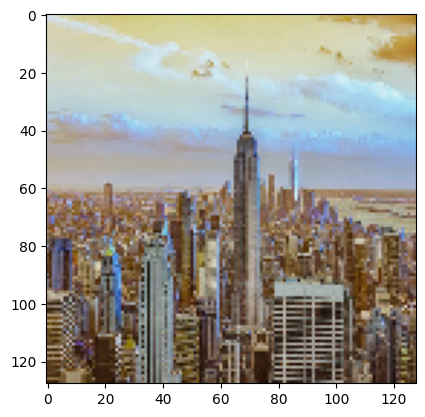

Iteration 100


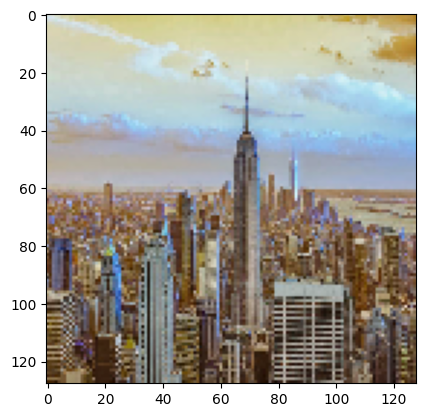

In [16]:
generated_img = tf.Variable(content_img, dtype=tf.float32)

content_feature, style_features = get_feature_representations(model, content_img, style_img)

optimizer = tf.optimizers.Adam(learning_rate=0.01)
iterations = 200

for i in range(iterations):
    grads = compute_gradients(content_feature, style_features, generated_img)
    optimizer.apply_gradients([(grads, generated_img)])

    if i % 100 == 0:
        print(f"Iteration {i}")
        img = deprocess_img(generated_img.numpy())
        plt.imshow(img)
        plt.show()

In [17]:
# Display the Final Image

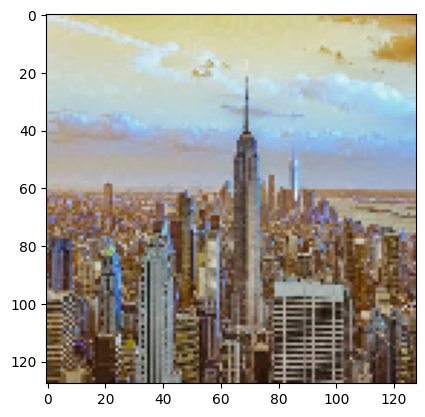

In [18]:
final_img = deprocess_img(generated_img.numpy())
plt.imshow(final_img)
plt.show()
